# Desafio Murabei

Nome: Akyla de Aquino Pinto

Email: akylaaquino@hotmail.com

## Objetivo

O objetivo do desafio é avaliar a organização do código e a capacidade de executar tarefas simples
de tratamento e modelagem de dados.

O modelo deve ser capaz de responder quais do tipo de escola (gênero misto, só de homens ou só de mulheres) é mais eficiente na formação de seus alunos de acordo com o resultado do exame
normalizado.


## Base de Dados

A base de dados fornecida foi extraída do curso de modelagem de Harvard 1 e está organizada em quatro arquivos diferentes:

**cat school data.csv:** Variáveis categóricas que são aplicadas às escolas.

**num school data.csv:** Variáveis numéricas que são aplicadas às escolas.

**cat student data.csv:** Variáveis categóricas que são aplicadas aos estudantes.

**num student data.csv:** Variáveis numéricas que são aplicadas aos estudantes.


### Descrição dos dados

Abaixo segue as variáveis e o nome para o qual serão traduzidas em português dentro dos colchetes []. 

**school:** ID da escola **[id_escola]**

**normexam:** Score do exame normalizado **[score_exame_norm]**

**schgend:** Gênero da escola **[genero_escola]**

**schavg:** Média do score para admissão na escola **[media_adm_escola]**

**vr:**  Faixa de pontuação de raciocínio verbal (rv) do aluno na admissão **[rv_adm_escola]**

**intake:** Faixa de pontuação de admissão do aluno, será aprovado[apro] ou reprovado[rep] **[faixa_pont_adm]**

**standLRT:** Pontuação do teste LR padronizado (Verossimilhança) **[Ver_padro]**

**sex:** Sexo dos estudantes, sendo posteriormente F (0) e M (1) **[gen_estud]**

**type:** Tipo de escola, sendo posteriormente Mxd (0) e Sngl (1) **[tipo_scola]**

**student:** ID do estudante na escola. **[ID_student]**


## Carregamento dos dados e dependências

In [806]:
import pandas as pd
import matplotlib.pyplot as plt

In [807]:
cat_school = pd.read_csv('data/bronze/cat_school_data.csv', sep=';')
cat_student = pd.read_csv('data/bronze/cat_student_data.csv', sep=';')
num_school = pd.read_csv('data/bronze/num_school_data.csv', sep=';')
num_student = pd.read_csv('data/bronze/num_student_data.csv', sep=';')

## Análise dos dados

### Vamos começar removendo e tratando dados faltantes ou duplicados nos dados

In [808]:
for df in [cat_school, cat_student, num_school, num_student]:
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)

#### cat_student e num_student

In [809]:
# cat_student.loc[(cat_student['student'] == 1) & (cat_student['school'] == 1)]
cat_student.head()

,school,student,variable,value
1,1,143,intake,bottom 25%
2,1,145,intake,mid 50%
3,1,142,intake,top 25%
4,1,141,intake,mid 50%
5,1,138,intake,mid 50%


In [810]:
num_student.head()


,school,student,variable,value
1,1,143.0,normexam,"0,2613242"
2,1,145.0,normexam,"0,1340672"
3,1,142.0,normexam,"-1,723882"
4,1,141.0,normexam,"0,9675862"
5,1,138.0,normexam,"0,5443412"


#### Vamos fazer um join sobre escola e id do estudante

In [811]:
student_data = pd.merge(cat_student, num_student, on=['school', 'student'], how='inner')
# inner garante que só serão considerados os registros que existem em ambos os dataframes
student_data.loc[(student_data['student'] == 1) & (student_data['school'] == 1)]
# Garantimos que o merge foi feito corretamente

,school,student,variable_x,value_x,variable_y,value_y
91,1,1,intake,bottom 25%,normexam,"1,5061852"
92,1,1,intake,bottom 25%,standLRT,"0,7843622"
7891,1,1,sex,F,normexam,"1,5061852"
7892,1,1,sex,F,standLRT,"0,7843622"
15636,1,1,vr,mid 50%,normexam,"1,5061852"
15637,1,1,vr,mid 50%,standLRT,"0,7843622"


Agora precisamos juntar as colunas variable_x e y com as colunas value_x e y

In [812]:
# Renomear colunas para unificar o formato
df_x = student_data.rename(columns={'variable_x': 'variable', 'value_x': 'value'})
df_y = student_data.rename(columns={'variable_y': 'variable', 'value_y': 'value'})

# Selecionar apenas as colunas que foram renomeadas
df_x = df_x[['school', 'student', 'variable', 'value']]
df_y = df_y[['school', 'student', 'variable', 'value']]

student_data = pd.concat([df_x, df_y], ignore_index=True)
student_data.head()


,school,student,variable,value
0,1,143,intake,bottom 25%
1,1,143,intake,bottom 25%
2,1,145,intake,mid 50%
3,1,145,intake,mid 50%
4,1,142,intake,top 25%


In [813]:
# Transformar a coluna 'variable' em colunas, lidando com duplicatas
student_data = student_data.pivot_table(
    index=['school','student'],        # Índices únicos
    columns='variable',       # Transformar esta coluna em colunas
    values='value',           # Preencher com valores desta coluna
    aggfunc='first'           # Pegar o primeiro valor em caso de duplicatas
).reset_index()

# Remove o nome das colunas variable e value
student_data.columns.name = None
student_data.head()


,school,student,intake,normexam,sex,standLRT,vr
0,1,1,bottom 25%,"1,5061852",F,"0,7843622",mid 50%
1,1,4,mid 50%,"-0,555112",F,"-1,03397",mid 50%
2,1,6,mid 50%,"-1,335315",M,"-0,951318",mid 50%
3,1,7,top 25%,"-0,555112",M,"-2,356393",mid 50%
4,1,13,mid 50%,"-0,197611",M,"-0,290107",mid 50%


In [814]:
# Vamos garantir que não existem valores duplicados ou nulos
student_data.dropna(inplace=True)
student_data.drop_duplicates(inplace=True)

#### Vamos realizar transformações nos valores categóricos e transformar para número, além de ajeitar as variáveis decimais mudando "," para "." e gerando dummies de intake e vr, onde 1 para True e 0 para False

In [815]:
# Começaremos transformando sexo F para 0 e M para 1
student_data['sex'] = student_data['sex'].replace({'F': 0, 'M': 1})
student_data['sex'].head(5)

C:\Users\Akyla\AppData\Local\Temp\ipykernel_9268\2980022099.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  student_data['sex'] = student_data['sex'].replace({'F': 0, 'M': 1})


0    0
1    0
2    1
3    1
4    1
Name: sex, dtype: int64

In [816]:
# Mudando ", " para "." e transformando em float
for col in ['normexam', 'standLRT']:
    student_data[col] = student_data[col].str.replace(',', '.').astype(float)
student_data[['normexam', 'standLRT']].head(5)


,normexam,standLRT
0,1.506185,0.784362
1,-0.555112,-1.033970
2,-1.335315,-0.951318
3,-0.555112,-2.356393
4,-0.197611,-0.290107


#### Vamos renomear as colunas

In [817]:
rename_dict = {
    "school": "id_escola",           
    "normexam": "score_exame_norm",         
    "vr": "rv_adm_escola",             
    "intake": "faixa_pont_adm",        
    "standLRT": "Ver_padro",           
    "sex": "gen_estud",                             
    "student": "id_estudante"            
}


student_data = student_data.rename(columns=rename_dict)

Agora vamos transformar as colunas intake e vr para dummies transformando em colunas

In [818]:
student_data = pd.get_dummies(student_data, columns=['faixa_pont_adm', 'rv_adm_escola'], dtype=int)
student_data.head(5)

,id_escola,id_estudante,score_exame_norm,gen_estud,Ver_padro,faixa_pont_adm_bottom 25%,faixa_pont_adm_mid 50%,faixa_pont_adm_top 25%,rv_adm_escola_bottom 25%,rv_adm_escola_mid 50%,rv_adm_escola_top 25%
0,1,1,1.506185,0,0.784362,1,0,0,0,1,0
1,1,4,-0.555112,0,-1.033970,0,1,0,0,1,0
2,1,6,-1.335315,1,-0.951318,0,1,0,0,1,0
3,1,7,-0.555112,1,-2.356393,0,0,1,0,1,0
4,1,13,-0.197611,1,-0.290107,0,1,0,0,1,0


#### Agora salvamos nosso dataframe na pasta silver.

In [819]:
student_data.to_csv('data/silver/student_data.csv', index=False)

### Agora faremos parecido para os dados escolares

In [820]:
school_data = pd.merge(cat_school, num_school, on='school', how='inner')

In [821]:
# Renomear colunas para unificar o formato
df_x = school_data.rename(columns={'variable_x': 'variable', 'value_x': 'value'})
df_y = school_data.rename(columns={'variable_y': 'variable', 'value_y': 'value'})

# Selecionar apenas as colunas que foram renomeadas
df_x = df_x[['school', 'variable', 'value']]
df_y = df_y[['school', 'variable', 'value']]
school_data = pd.concat([df_x, df_y], ignore_index=True)


In [822]:
student_data.head()

,id_escola,id_estudante,score_exame_norm,gen_estud,Ver_padro,faixa_pont_adm_bottom 25%,faixa_pont_adm_mid 50%,faixa_pont_adm_top 25%,rv_adm_escola_bottom 25%,rv_adm_escola_mid 50%,rv_adm_escola_top 25%
0,1,1,1.506185,0,0.784362,1,0,0,0,1,0
1,1,4,-0.555112,0,-1.033970,0,1,0,0,1,0
2,1,6,-1.335315,1,-0.951318,0,1,0,0,1,0
3,1,7,-0.555112,1,-2.356393,0,0,1,0,1,0
4,1,13,-0.197611,1,-0.290107,0,1,0,0,1,0


In [823]:
school_data = school_data.pivot_table(
    index='school',        
    columns='variable',       
    values='value',           
    aggfunc='first'           
)

school_data.columns.name = None
school_data.dropna(inplace=True)
school_data.drop_duplicates(inplace=True)

In [824]:
school_data.head()

,schavg,schgend,type
school,,,
1,"0,1661752",mixed,Mxd
2,"0,3951492",girls,Sngl
3,"0,5141552",mixed,Mxd
4,"0,0917642",mixed,Mxd
5,"0,2105252",mixed,Mxd


In [825]:
# Corrigindo os valores decimais
for col in ['schavg']:
    school_data[col] = school_data[col].str.replace(',', '.').astype(float)

In [826]:
# Gerando dummies
school_data = pd.get_dummies(school_data, columns=['schgend'], dtype=int)

#### Vamos considerar que Mxd = 0 e Sngl = 1

In [827]:
# Mudando type para int
school_data['type'] = school_data['type'].replace({'Mxd': 0, 'Sngl': 1})

C:\Users\Akyla\AppData\Local\Temp\ipykernel_9268\858011042.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  school_data['type'] = school_data['type'].replace({'Mxd': 0, 'Sngl': 1})


In [828]:
school_data.head()
school_data.reset_index(inplace=True)

In [829]:
rename_dict = {            
    "schgend": "genero_escola",        
    "schavg": "media_adm_escola",                     
    "type": "tipo_escola", 
    "school": "id_escola"        
}

school_data = school_data.rename(columns=rename_dict)
school_data.head(5)

,id_escola,media_adm_escola,tipo_escola,schgend_boys,schgend_girls,schgend_mixed
0,1,0.166175,0,0,0,1
1,2,0.395149,1,0,1,0
2,3,0.514155,0,0,0,1
3,4,0.091764,0,0,0,1
4,5,0.210525,0,0,0,1


#### Salvando na pasta Silver

In [830]:
school_data.to_csv('data/silver/school_data.csv', index=False)

### Para terminar iremos fazer o merge dos dados com alunos e escola

In [831]:
final_data = pd.merge(student_data, school_data, on='id_escola', how='inner')
final_data.dropna(inplace=True)
final_data.drop_duplicates(inplace=True)

In [832]:
final_data.head()

,id_escola,id_estudante,score_exame_norm,gen_estud,Ver_padro,faixa_pont_adm_bottom 25%,faixa_pont_adm_mid 50%,faixa_pont_adm_top 25%,rv_adm_escola_bottom 25%,rv_adm_escola_mid 50%,rv_adm_escola_top 25%,media_adm_escola,tipo_escola,schgend_boys,schgend_girls,schgend_mixed
0,1,1,1.506185,0,0.784362,1,0,0,0,1,0,0.166175,0,0,0,1
1,1,4,-0.555112,0,-1.033970,0,1,0,0,1,0,0.166175,0,0,0,1
2,1,6,-1.335315,1,-0.951318,0,1,0,0,1,0,0.166175,0,0,0,1
3,1,7,-0.555112,1,-2.356393,0,0,1,0,1,0,0.166175,0,0,0,1
4,1,13,-0.197611,1,-0.290107,0,1,0,0,1,0,0.166175,0,0,0,1


#### Salvamos para nossa pasta gold

In [833]:
final_data.to_csv('data/gold/final_data.csv', index=False)

## Análise e Treinamento do Modelo

Nosso objetivo é que o nosso modelo possa dar uma resposta bem aproximada do normexam (score_exame_norm)

In [843]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [835]:
df = pd.read_csv('data/gold/final_data.csv')

In [836]:
df.head()

,id_escola,id_estudante,score_exame_norm,gen_estud,Ver_padro,faixa_pont_adm_bottom 25%,faixa_pont_adm_mid 50%,faixa_pont_adm_top 25%,rv_adm_escola_bottom 25%,rv_adm_escola_mid 50%,rv_adm_escola_top 25%,media_adm_escola,tipo_escola,schgend_boys,schgend_girls,schgend_mixed
0,1,1,1.506185,0,0.784362,1,0,0,0,1,0,0.166175,0,0,0,1
1,1,4,-0.555112,0,-1.033970,0,1,0,0,1,0,0.166175,0,0,0,1
2,1,6,-1.335315,1,-0.951318,0,1,0,0,1,0,0.166175,0,0,0,1
3,1,7,-0.555112,1,-2.356393,0,0,1,0,1,0,0.166175,0,0,0,1
4,1,13,-0.197611,1,-0.290107,0,1,0,0,1,0,0.166175,0,0,0,1


In [837]:
min_val = df['score_exame_norm'].min()
max_val = df['score_exame_norm'].max()

print(f"Valor mínimo: {min_val}")
print(f"Valor máximo: {max_val}")


Valor mínimo: -3.666072
Valor máximo: 3.6660912


Vamos regularizar nosso score_exame_norm com MinMaxScaler, pois fica mais fácil entender e visualizar os dados, aplicaremos em
'score_exame_norm', 'Ver_padro', 'media_adm_escola', pois remetem a nota, normalizando de 0 a 1 entendemos que quanto mais proximo de 1 mais proximo de 100

In [838]:

scaler = MinMaxScaler()

df[['score_exame_norm', 'Ver_padro', 'media_adm_escola']] = scaler.fit_transform(df[['score_exame_norm', 'Ver_padro', 'media_adm_escola']])

df.head()


,id_escola,id_estudante,score_exame_norm,gen_estud,Ver_padro,faixa_pont_adm_bottom 25%,faixa_pont_adm_mid 50%,faixa_pont_adm_top 25%,rv_adm_escola_bottom 25%,rv_adm_escola_mid 50%,rv_adm_escola_top 25%,media_adm_escola,tipo_escola,schgend_boys,schgend_girls,schgend_mixed
0,1,1,0.705420,0,0.625000,1,0,0,0,1,0,0.661685,0,0,0,1
1,1,4,0.424290,0,0.319444,0,1,0,0,1,0,0.661685,0,0,0,1
2,1,6,0.317881,1,0.333333,0,1,0,0,1,0,0.661685,0,0,0,1
3,1,7,0.424290,1,0.097222,0,0,1,0,1,0,0.661685,0,0,0,1
4,1,13,0.473047,1,0.444444,0,1,0,0,1,0,0.661685,0,0,0,1


In [860]:
min_val = df['score_exame_norm'].min()
max_val = df['score_exame_norm'].max()

print(f"Valor mínimo: {min_val}")
print(f"Valor máximo: {max_val}")


Valor mínimo: 0.0
Valor máximo: 1.0


#### Vamos visualizar nossos dados

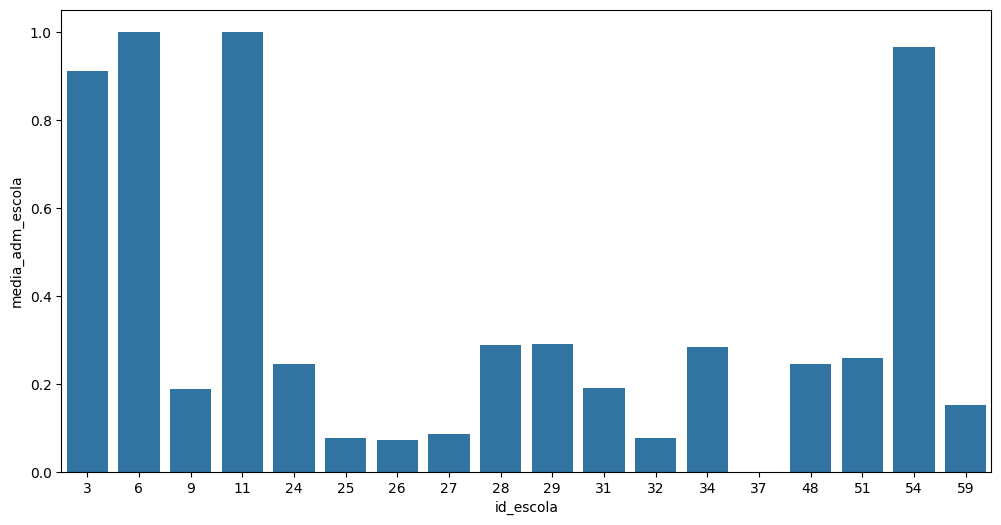

In [873]:
# Definir o tamanho da figura
plt.figure(figsize=(12, 6))  # Largura de 12 polegadas e altura de 6 polegadas

# Criar o gráfico
sns.barplot(x='id_escola', y='media_adm_escola', data=df.loc[(df['media_adm_escola'] >= 0.9) | (df['media_adm_escola'] <= 0.3)])

# Exibir o gráfico
plt.show()

<Axes: xlabel='id_escola', ylabel='score_exame_norm'>

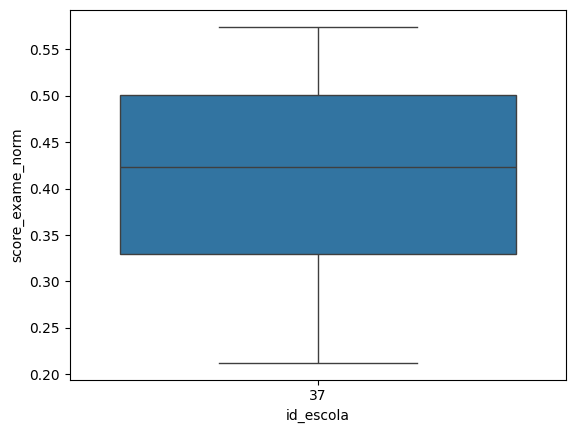

In [874]:
sns.boxplot(x='id_escola', y='score_exame_norm', data=df.loc[df['id_escola'] == 37]) 